### Описание проблемы языка жестов (American Sign Language)

American Sign Language (ASL) - это полный, естественный язык, который имеет те же лингвистические свойства, что и разговорные языки, с грамматикой, которая отличается от английского языка. ASL выражается движениями рук и лица. Это основной язык многих североамериканцев, которые являются глухими и слабослышащими, а также используется многими слышащими людьми. Формат набора данных является шаблоном, который точно соответствует классическому MNIST. Каждый учебный и тестовый случай представляет собой метку (0-25) в виде карты один к одному для каждой буквы алфавита A-Z (и никаких случаев для 9=J или 25=Z из-за жестовых движений). 

Обучающие данные (27 455 случаев) и тестовые данные (7172 случая) примерно вдвое меньше стандартного MNIST, но в остальном аналогичны с заголовочной строкой метки pixel1,pixel2....pixel784, которые представляют собой одно изображение размером 28x28 пикселей со значениями оттенков серого в диапазоне 0-255. Исходные данные изображения жеста руки представляли собой несколько пользователей, повторяющих этот жест на разных фонах. Данные языка жестов пришли от значительно расширяющегося небольшого числа (1704) цветных изображений, включенных как не обрезанные вокруг интересующей области руки. Для создания новых данных был использован конвейер изображений, основанный на ImageMagick и включающий обрезку только для рук, серое масштабирование, изменение размера, а затем создание по крайней мере 50+ вариаций для увеличения количества.

<img src="https://user-images.githubusercontent.com/54672403/84397611-81c2d780-ac07-11ea-8fe5-f762c536a025.png">

In [1]:
import pandas as pd
pd.options.display.max_rows = 10
pd.options.display.max_columns = 15
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPooling2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
UPPER_case= 'ABCDEFGHIKLMNOPQRSTUVWXY'

def draw_acc(history):
    hist = history.history
    x_arr = np.arange(len(hist['loss'])) + 1

    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
    ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
    ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)

    plt.show()

Using TensorFlow backend.


In [2]:
!tree MNIST

MNIST
├── american_sign_language.PNG
├── amer_sign2.png
├── amer_sign3.png
├── sign_mnist_test
│   └── sign_mnist_test.csv
├── sign_mnist_test.csv
├── sign_mnist_train
│   └── sign_mnist_train.csv
└── sign_mnist_train.csv

2 directories, 7 files


In [3]:
train_df = pd.read_csv("MNIST/sign_mnist_train/sign_mnist_train.csv")
test_df = pd.read_csv("MNIST/sign_mnist_test/sign_mnist_test.csv")
test = pd.read_csv("MNIST/sign_mnist_test.csv")
y = test['label']
train_df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,...,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,...,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,...,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,...,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,...,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,...,108,133,163,157,163,164,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,13,189,189,190,190,192,193,...,77,52,200,234,200,222,225
27451,23,151,154,157,158,160,161,...,198,198,196,195,195,195,194
27452,18,174,174,174,174,174,175,...,208,206,204,203,202,200,200
27453,17,177,181,184,185,187,189,...,58,102,79,47,64,87,93


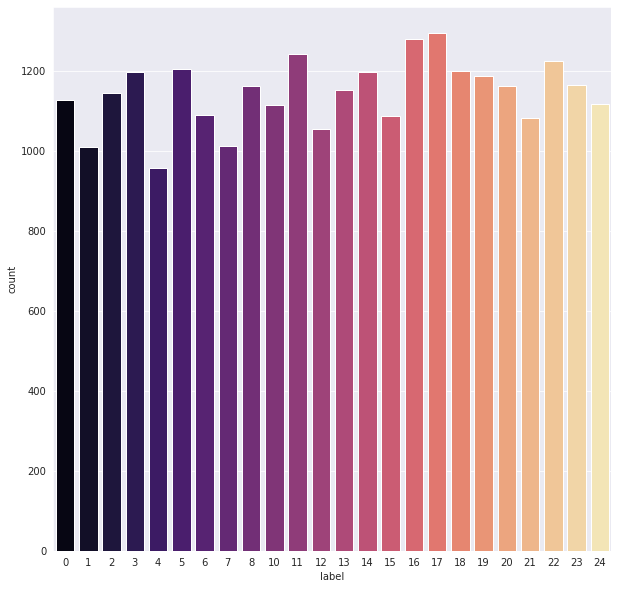

In [4]:
plt.figure(figsize = (10,10)) # Label Count
sns.set_style("darkgrid")
sns.countplot(train_df['label'],  palette='magma');

Набор данных кажется сбалансированным, поскольку для каждой обучающей метки существует достаточное количество обучающих примеров

In [5]:
y_train = train_df['label']
y_test = test_df['label']
del train_df['label'], test_df['label'] # !!!

In [6]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train_hot = label_binarizer.fit_transform(y_train)
y_test_hot = label_binarizer.fit_transform(y_test)

In [7]:
x_train = train_df.values
x_test = test_df.values

Мы выполняем нормализацию оттенков серого, чтобы уменьшить влияние различной освещенности. Более того, CNN сходится быстрее на данных в промежутке [0..1] , чем на [0..255].

In [8]:
# Normalize the data
x_train = x_train / 255
x_test = x_test / 255
# Reshaping data 1-D ~> 3-D
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

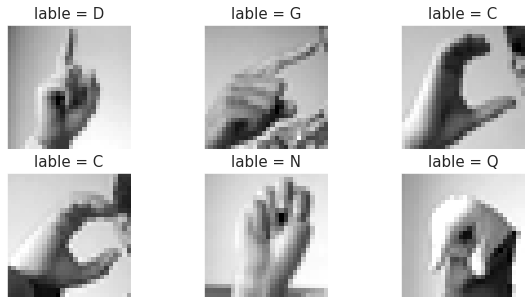

In [9]:
fig = plt.figure(figsize=(10, 5))
for i in range(0, 6):
    #print(example[0].shape, example[1].numpy())
    ax = fig.add_subplot(2, 3, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(x_train[i].reshape(28, 28), cmap="gray")
    ax.set_title(f'lable = {UPPER_case[np.argmax(y_train_hot[i])]}', size=15)
    

### Building the CNN Model

In [11]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(4,4), activation = 'relu',
                 input_shape=(28, 28 ,1), padding='same' ))
model.add(Dropout(0.4))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, kernel_size = (4, 4), activation = 'relu', padding='same'))
model.add(Dropout(0.4))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
model.add(Dropout(0.4))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(24,activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        1088      
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        65600     
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 64)         

In [12]:
model.compile(loss = 'categorical_crossentropy',
              optimizer='nadam', metrics=['accuracy'])

In [17]:
history = model.fit(x_train, y_train,
                    validation_data = (x_test, y_test_hot),
                    epochs=30, batch_size=128)

Train on 27455 samples, validate on 7172 samples
Epoch 1/30
27455/27455 [==============================] - 89s 3ms/step - loss: 1.5305 - accuracy: 0.5120 - val_loss: 0.9882 - val_accuracy: 0.8293
Epoch 2/30
27455/27455 [==============================] - 94s 3ms/step - loss: 0.2918 - accuracy: 0.8964 - val_loss: 0.5313 - val_accuracy: 0.8813
Epoch 3/30
27455/27455 [==============================] - 81s 3ms/step - loss: 0.1286 - accuracy: 0.9564 - val_loss: 0.2951 - val_accuracy: 0.9564
Epoch 4/30
27455/27455 [==============================] - 80s 3ms/step - loss: 0.0756 - accuracy: 0.9758 - val_loss: 0.2256 - val_accuracy: 0.9625
Epoch 5/30
27455/27455 [==============================] - 80s 3ms/step - loss: 0.0554 - accuracy: 0.9808 - val_loss: 0.2353 - val_accuracy: 0.9557
Epoch 6/30
27455/27455 [==============================] - 81s 3ms/step - loss: 0.0385 - accuracy: 0.9870 - val_loss: 0.1627 - val_accuracy: 0.9661
Epoch 7/30
27455/27455 [==============================] - 79s 3ms/ste

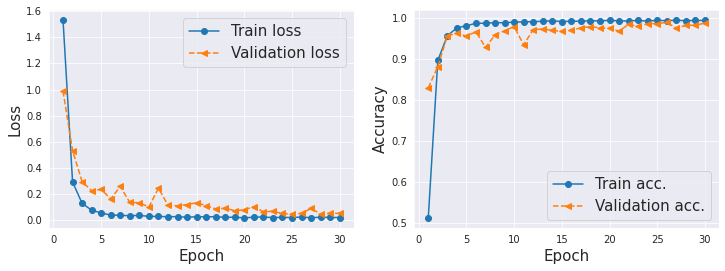

In [20]:
draw_acc(history)draw_acc(history)

### Предположим, что у нас в 100 раз меньше данных

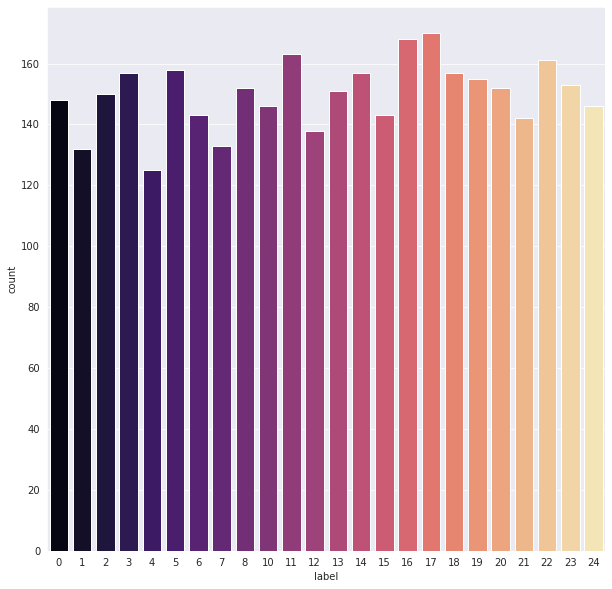

In [9]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, random_state=1,
                                                    train_size=180*24, test_size=150*24, 
                                                    stratify=y_train)
plt.figure(figsize = (10,10)) # Label Count
sns.set_style("darkgrid")
sns.countplot(y_test,  palette='magma');

In [25]:
label_binarizer = LabelBinarizer()
y_train_hot = label_binarizer.fit_transform(y_train)
y_test_hot = label_binarizer.fit_transform(y_test)

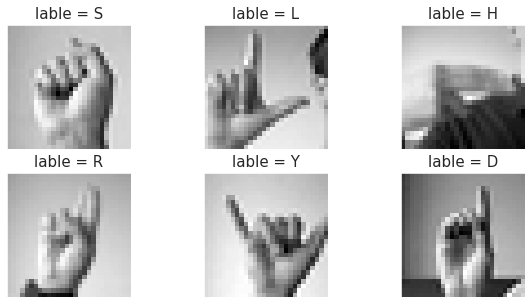

In [14]:
## проверка на сходимость меток и переменных
fig = plt.figure(figsize=(10, 5))
for i in range(0, 6):
    ax = fig.add_subplot(2, 3, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(x_train[i].reshape(28, 28), cmap="gray")
    ax.set_title(f'lable = {UPPER_case[np.argmax(y_train_hot[i])]}', size=15)
    

In [15]:
from keras.preprocessing.image import ImageDataGenerator
# Setup data augmentation img generator - random transformations
datagen = ImageDataGenerator(
    shear_range = 0.25,
    zoom_range = 0.15,
    rotation_range = 15,
    brightness_range = [0.15, 1.15],
    width_shift_range = [-2,-1, 0, +1, +2],
    height_shift_range = [ -1, 0, +1],
    fill_mode = 'reflect')

In [16]:
# Setup data augmentation img generator - random transformations
datagen2 = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

Shape: (28, 28, 1)


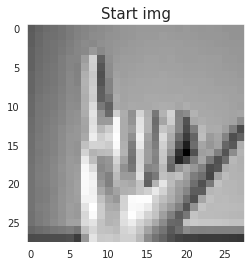

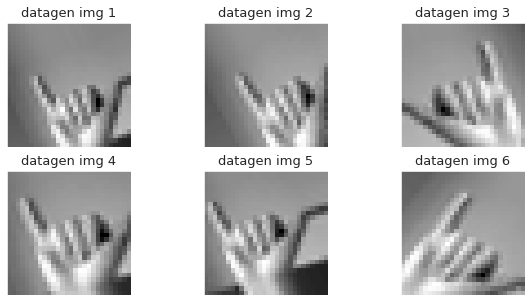

In [17]:
from keras.preprocessing import image
start_img = x_train[7]
plt.imshow(start_img.reshape(28, 28), cmap="gray")
plt.title('Start img', size=15)
plt.grid(False)
print ('Shape:', start_img.shape)
x = start_img.reshape((1,) + start_img.shape)

fig = plt.figure(figsize=(10, 5))
i=0
for batch in datagen2.flow(x, batch_size=1):
    ax = fig.add_subplot(2, 3, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(image.array_to_img(batch[0]), cmap="gray")
    ax.set_title(f'datagen img {i+1}', size=13)
    i += 1
    if i % 6 == 0:
        break
plt.show()

In [68]:
model=Sequential()
model.add(Conv2D(128,kernel_size=(5,5),
                 strides=1,padding='same',activation='relu',input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(3,3),strides=2,padding='same'))
model.add(Conv2D(64,kernel_size=(2,2),
                 strides=1,activation='relu',padding='same'))
model.add(MaxPooling2D((2,2),2,padding='same'))
model.add(Conv2D(32,kernel_size=(2,2),
                 strides=1,activation='relu',padding='same'))
model.add(MaxPooling2D((2,2),2,padding='same'))
model.add(Flatten())

model.add(Dense(units=512,activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=24,activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 128)       3328      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 64)        32832     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 32)          8224      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)              

In [69]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Модель без генератора фото

In [70]:
history = model.fit(x_train, y_train_hot,
                    validation_data = (x_test, y_test_hot),
                    epochs=30, batch_size=128)

Train on 4320 samples, validate on 3600 samples
Epoch 1/30
4320/4320 [==============================] - 14s 3ms/step - loss: 3.1740 - accuracy: 0.0539 - val_loss: 3.1565 - val_accuracy: 0.0747
Epoch 2/30
4320/4320 [==============================] - 12s 3ms/step - loss: 2.9185 - accuracy: 0.1519 - val_loss: 2.2431 - val_accuracy: 0.3556
Epoch 3/30
4320/4320 [==============================] - 13s 3ms/step - loss: 1.7841 - accuracy: 0.4356 - val_loss: 1.1907 - val_accuracy: 0.6319
Epoch 4/30
4320/4320 [==============================] - 14s 3ms/step - loss: 1.0244 - accuracy: 0.6632 - val_loss: 0.7554 - val_accuracy: 0.7639
Epoch 5/30
4320/4320 [==============================] - 13s 3ms/step - loss: 0.6404 - accuracy: 0.7877 - val_loss: 0.4602 - val_accuracy: 0.8542
Epoch 6/30
4320/4320 [==============================] - 12s 3ms/step - loss: 0.4617 - accuracy: 0.8456 - val_loss: 0.3610 - val_accuracy: 0.8861
Epoch 7/30
4320/4320 [==============================] - 11s 3ms/step - loss: 0.332

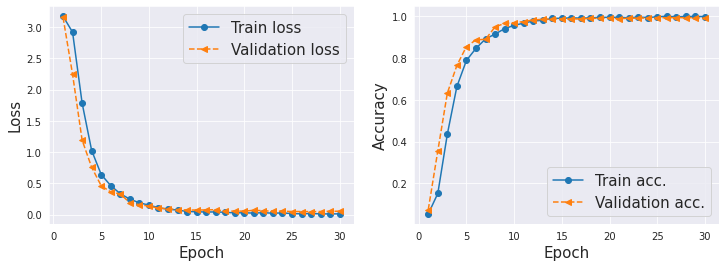

In [71]:
draw_acc(history)

history = model.fit(x_train, y_train_hot,
                    validation_data = (x_test, y_test_hot),
                    epochs=30, batch_size=128)

## Модель c генератором фото

In [56]:
x_train = x_train.reshape(-1,28,28,1)
print(x_train.shape,y_train_hot.shape,x_test.shape,y_test_hot.shape)

(4320, 28, 28, 1) (4320, 24) (3600, 28, 28, 1) (3600, 24)


In [29]:
# Create an ImageDataGenerator and do Image Augmentation
train_datagen = ImageDataGenerator(rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.1,
                                   zoom_range=0.2)

In [30]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
ankitz = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.75, min_lr=0.00001)

history = model.fit_generator(train_datagen.flow(x_train, y_train_hot, batch_size=128),
                              epochs = 30,
                              validation_data= (x_test, y_test_hot),
                              callbacks = [ankitz])

Epoch 1/30
34/34 [==============================] - 14s 418ms/step - loss: 3.1812 - accuracy: 0.0426 - val_loss: 3.1729 - val_accuracy: 0.0503
Epoch 2/30
34/34 [==============================] - 17s 511ms/step - loss: 3.1418 - accuracy: 0.0692 - val_loss: 3.1042 - val_accuracy: 0.0836
Epoch 3/30
34/34 [==============================] - 16s 481ms/step - loss: 2.8466 - accuracy: 0.1514 - val_loss: 2.7245 - val_accuracy: 0.3133
Epoch 4/30
34/34 [==============================] - 16s 465ms/step - loss: 2.4306 - accuracy: 0.2519 - val_loss: 2.4024 - val_accuracy: 0.4533
Epoch 5/30
34/34 [==============================] - 16s 473ms/step - loss: 2.1180 - accuracy: 0.3356 - val_loss: 2.1740 - val_accuracy: 0.5158
Epoch 6/30
34/34 [==============================] - 16s 464ms/step - loss: 1.8552 - accuracy: 0.4032 - val_loss: 1.9526 - val_accuracy: 0.5747
Epoch 7/30
34/34 [==============================] - 14s 426ms/step - loss: 1.6627 - accuracy: 0.4519 - val_loss: 1.7509 - val_accuracy: 0.6733

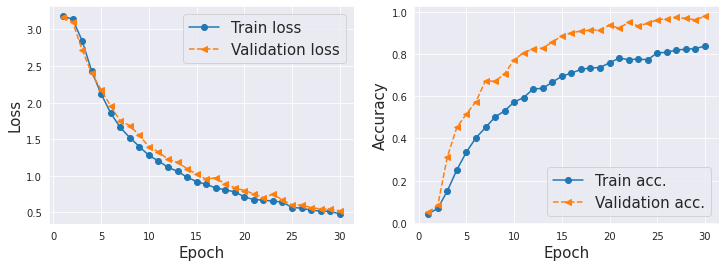

In [31]:
draw_acc(history)